# Group level analysis to test associations between symptomology and gray matter density in children

### Multivariate Analysis

In [1]:
from pandas import DataFrame, Series, read_csv

# Study specific variables
study_home = '/home/camachocm2/Analysis/aggregate_anats'
moochie_home = '/moochie/user_data/CamachoCat/Aggregate_anats'
sub_data_file = moochie_home + '/doc/subject_info_alex.csv'
subject_info = read_csv(sub_data_file, index_col=None)
subjects_list = subject_info['freesurferID'].tolist()

preproc_dir = moochie_home + '/proc/subj_data'
output_dir = moochie_home + '/proc/Alex_project/SVR'
sample_template = moochie_home + '/templates/lcbd_template_1mm.nii.gz'
sample_template_brain = moochie_home + '/templates/lcbd_template_1mm_brain.nii.gz'
sample_template_mask = moochie_home + '/templates/lcbd_template_1mm_mask.nii.gz'

subject_info.describe()

,Age_yrs,male,eTIV,cbcl_intern,cbcl_extern,cbcl_total
count,142.000000,142.000000,1.420000e+02,142.000000,142.000000,142.000000
mean,7.775747,0.535211,1.477432e+06,6.126761,8.732394,14.859155
std,1.824117,0.500524,1.392444e+05,7.457548,10.981555,17.041706
min,4.169747,0.000000,1.142335e+06,0.000000,0.000000,0.000000
25%,6.468857,0.000000,1.385005e+06,1.000000,1.000000,4.000000
50%,7.597536,1.000000,1.487114e+06,4.000000,5.000000,8.000000
75%,8.827515,1.000000,1.573732e+06,8.750000,11.000000,21.500000
max,12.851472,1.000000,1.943317e+06,47.000000,46.000000,76.000000


In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from numpy import squeeze

## Create a conditions list for the feature set
age_labels = subject_info[['Age_yrs']].copy()
age_labels = age_labels.values
agesq_labels = age_labels*age_labels
sx_labels = subject_info[['cbcl_intern','cbcl_extern','cbcl_total']].copy()
sx_labels = sx_labels.values

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(age_labels)
sd_agedata = scaler.transform(age_labels)
scaler.fit(agesq_labels)
sd_agesqdata = scaler.transform(agesq_labels)

pt = PowerTransformer()
pt.fit(sx_labels)
pt_sx = pt.transform(sx_labels)
pt_sx = squeeze(pt_sx)

subject_info = subject_info.merge(DataFrame(pt_sx,
                                            columns=['cbcl_intern_yj','cbcl_extern_yj','cbcl_total_yj'],
                                            index=subject_info.index),left_index=True, right_index=True)
subject_info['age_cent'] = sd_agedata
subject_info['age_sq'] = sd_agedata*sd_agedata

subject_info.to_csv(output_dir + '/featureset_key.csv')
subject_info.describe()

,Age_yrs,male,eTIV,cbcl_intern,cbcl_extern,cbcl_total,cbcl_intern_yj,cbcl_extern_yj,cbcl_total_yj,age_cent,age_sq
count,142.000000,142.000000,1.420000e+02,142.000000,142.000000,142.000000,1.420000e+02,1.420000e+02,1.420000e+02,1.420000e+02,142.000000
mean,7.775747,0.535211,1.477432e+06,6.126761,8.732394,14.859155,1.250956e-17,-2.376815e-16,5.003822e-17,1.376051e-16,1.000000
std,1.824117,0.500524,1.392444e+05,7.457548,10.981555,17.041706,1.003540e+00,1.003540e+00,1.003540e+00,1.003540e+00,1.447018
min,4.169747,0.000000,1.142335e+06,0.000000,0.000000,0.000000,-1.503212e+00,-1.436966e+00,-1.793387e+00,-1.983844e+00,0.000002
25%,6.468857,0.000000,1.385005e+06,1.000000,1.000000,4.000000,-7.824809e-01,-8.157931e-01,-5.452621e-01,-7.189867e-01,0.114576
50%,7.597536,1.000000,1.487114e+06,4.000000,5.000000,8.000000,1.428441e-01,1.402709e-01,-4.347115e-02,-9.804292e-02,0.443412
75%,8.827515,1.000000,1.573732e+06,8.750000,11.000000,21.500000,7.970878e-01,7.259981e-01,7.918174e-01,5.786314e-01,1.167667
max,12.851472,1.000000,1.943317e+06,47.000000,46.000000,76.000000,2.299302e+00,1.841445e+00,2.026476e+00,2.792415e+00,7.797580


In [3]:
## Concatenate all the parameter estimates from preproc to create a feature set
from nipype.interfaces.fsl.utils import Merge

gm_template = preproc_dir + '/final_gmd/{0}/final_smooth_gm_4.nii.gz'
gm_files = []
for sub in subjects_list:
    gm_files.append(gm_template.format(sub))
gmd_feature_data = output_dir + '/gmd_combined_4.nii.gz'
#print(gm_files)

merge = Merge()
merge.inputs.in_files = gm_files
merge.inputs.dimension = 't'
merge.inputs.merged_file = gmd_feature_data
#merge.run()

191203-14:31:07,346 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.3.1)


In [15]:
from nilearn.input_data import NiftiMasker

analysis = 'total_sxs'
masker = NiftiMasker(mask_img=sample_template_mask,standardize=True, 
                     memory='nilearn_cache', memory_level=1)
X = masker.fit_transform(gmd_feature_data)

if analysis == 'age':
    labels = subject_info['age_cent']
    groups = subject_info['freesurferID']
elif analysis == 'age_sq':
    labels = subject_info['age_sq']
    groups = subject_info['freesurferID']
elif analysis == 'internalizing':
    labels = subject_info['cbcl_intern_yj']
    groups = subject_info['freesurferID']
elif analysis == 'externalizing':
    labels = subject_info['cbcl_extern_yj']
    groups = subject_info['freesurferID']
elif analysis == 'total_sxs':
    labels = subject_info['cbcl_total_yj']
    groups = subject_info['freesurferID']
elif analysis == 'icv':
    labels = subject_info['eTIV']
    groups = subject_info['freesurferID']

results_file = open(output_dir + '/results_' + analysis + '.txt','w')
labels.describe()

count    1.420000e+02
mean     5.003822e-17
std      1.003540e+00
min     -1.793387e+00
25%     -5.452621e-01
50%     -4.347115e-02
75%      7.918174e-01
max      2.026476e+00
Name: cbcl_total_yj, dtype: float64

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


prediction accuracy: 0.1868 / p-value: 0.026035 / MSE: 0.976771 // Spearman: 0.148938 / p-value: 0.076895


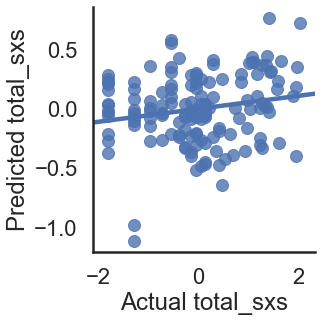

In [16]:
# Perform the support vector classification
from nilearn.input_data import NiftiMasker
from sklearn.feature_selection import f_regression, SelectPercentile
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from pandas import DataFrame, Series

# Set up the regression
svr = SVR(kernel='linear', C=1)

feature_selection = SelectPercentile(f_regression, percentile=5)
fs_svr = Pipeline([('feat_select', feature_selection), ('svr', svr)])

# Run the regression
fs_svr.fit(X, labels)

from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, RepeatedKFold

cv = LeaveOneGroupOut()
y_pred = cross_val_predict(fs_svr, X, y=labels, n_jobs=10, groups=groups, cv=cv)

# save weights
coef = svr.coef_
coef = feature_selection.inverse_transform(coef)
coef_image = masker.inverse_transform(coef)
coef_image.to_filename(output_dir + '/svrweights_' + analysis + '.nii.gz')

from scipy.stats import linregress
slope, intercept, r_val, p_val, stderr = linregress(labels, y_pred) 

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(labels, y_pred)

from scipy.stats import spearmanr
spear_r, spear_p = spearmanr(labels, y_pred)

print('prediction accuracy: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f' % (r_val, p_val, mse, spear_r, spear_p))

svr_results=DataFrame()
svr_results['labels']=labels
svr_results['y_pred']=Series(y_pred,index=labels.index)
# plot the predicted versus actual values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster',style='white')
sns.lmplot(x='labels', y='y_pred',ci=None,data=svr_results)
plt.xlabel('Actual ' + analysis)
plt.ylabel('Predicted ' + analysis)
plt.savefig(output_dir + '/scatter_pred_actual_' + analysis + '_poster.svg')
plt.show()
plt.close()

results_file.write('Prediction accuracy r-value: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f \n' % (r_val, p_val, mse, spear_r, spear_p))

results_file.close()

In [ ]:
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from numpy import savetxt

results_file = open(output_dir + '/perm_results_' + analysis + '.txt','w')

score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, labels, scoring='neg_mean_squared_error', 
                                                           cv=cv, n_permutations=50, n_jobs=20, groups=groups)
savetxt(output_dir + '/permutation_scores_mse_' + analysis + '.txt', permutation_scores)

# Save a figure of the permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Mean Squared Error (pvalue %f)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig(output_dir + '/permutation_plot_mse_' + analysis + '.svg', transparent=True)
plt.close()

# save final pval/classifier score
results_file.write('MSE score %s (pvalue : %s) \n' % (score, pvalue))

## Perform permutation testing to get a p-value for r-squared
score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, labels, scoring='r2', 
                                                           cv=cv, n_permutations=500, n_jobs=20, groups=groups)
savetxt(output_dir + '/permutation_scores_r2_' + analysis + '.txt', permutation_scores)

# Save a figure of the permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='R-squared (pvalue %f)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig(output_dir + '/permutation_plot_r2_' + analysis + '.svg', transparent=True)
plt.close()

# save final pval/classifier score
results_file.write('R square: %s (pvalue : %s) \n' % (score, pvalue))
results_file.close()

### Mixed-Effects Linear Modeling

In [25]:
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber

# Study specific variables
study_home = '/home/camachocm2/Analysis/aggregate_anats'
moochie_home = '/moochie/user_data/CamachoCat/Aggregate_anats'
transf_data = moochie_home + '/proc/Alex_project/SVR/featureset_key.csv'
subject_info = read_csv(transf_data, index_col=0)

preproc_dir = moochie_home + '/proc/subj_data'
output_dir = moochie_home + '/proc/Alex_project/MELM'
sample_template_mask = moochie_home + '/templates/lcbd_template_1mm_mask.nii.gz'

gmd_feature_data = moochie_home + '/proc/Alex_project/SVR/gmd_combined_4.nii.gz'

In [ ]:
import statsmodels.formula.api as smf
from numpy import zeros_like, array
from pandas import DataFrame, read_csv, Series, concat
from nilearn.masking import apply_mask, unmask

# Load the brain data
gmd_data = apply_mask(gmd_feature_data, sample_template_mask)

for analysis in ['cbcl_intern_yj','cbcl_extern_yj','cbcl_total_yj']:
    # Preallocate the output arrays
    pvals_data = zeros_like((5,gmd_data.shape[1])).astype(float)
    coeffs_data = zeros_like((5,gmd_data.shape[1])).astype(float)
    zstat_data = zeros_like((5,gmd_data.shape[1])).astype(float)

    # define the mixed effects model
    formula = 'gmd ~ age_cent + {0} + eTIV'.format(analysis)
    
    for x in range(0,gmd_data.shape[0]):
        subject_info['gmd'] = gmd_data[:,x]
        model = smf.mixedlm(formula, subject_info, groups=subject_info['male'])
        fitted_model = model.fit()
        pvals_data[:,x] = array(fitted_model.pvalues)
        coeffs_data[:,x] = array(fitted_model.params)
        tstat_data[:,x] = array(fitted_model.tvalues)
        
    #save the voxel-wise results as niftis
    pvals_image = unmask(pvals_data, sample_template_mask)
    pvals_image.to_csv(output_dir = moochie_home + '/proc/Alex_project/MELM' + '/{0}_pvalues.nii.gz'.format(analysis))
    coeff_image = unmask(coeffs_data, sample_template_mask)
    coeff_image.to_csv(output_dir = moochie_home + '/proc/Alex_project/MELM' + '/{0}_coefficients.nii.gz'.format(analysis))
    tstat_image = unmask(tstat_data, sample_template_mask)
    tstat_image.to_csv(output_dir = moochie_home + '/proc/Alex_project/MELM' + '/{0}_tstats.nii.gz'.format(analysis))

In [41]:
import numpy as np
np.array(fitted_model.pvalues)

array([4.70086904e-05, 3.98403455e-01, 2.40200073e-02, 2.06084903e-01,
       5.36064788e-01])

In [ ]:

labels=labels['region_name']

masker = NiftiLabelsMasker(labels_img=atlas, background_label=0)
time_series = masker.fit_transform(func)
time_series_df = DataFrame(data=time_series, columns=labels)